In [ ]:
import librosa
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install joblib

In [ ]:
import joblib

# Define the path to your saved Random Forest model
model_filename = '/content/drive/My Drive/text_model.pkl'

# Load the model
text_model = joblib.load(model_filename)

In [ ]:
# Load the face model
face_model = keras.models.load_model('/content/drive/MyDrive/Datasets1/face_model_final.h5')

# Load the voice model
voice_model = keras.models.load_model('/content/drive/MyDrive/models/voice_model_final.h5')

In [ ]:
sampling_rate = 22050
max_input_length = 286155
emotions = ['Anxiety', 'Happiness', 'Sadness']
def load_and_preprocess_audio(file_path, target_length=max_input_length):
    audio, _ = librosa.load(file_path, sr=sampling_rate, duration=None)

    # Pad or truncate audio to the target length
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        audio = audio[:target_length]

    # Extract features (as before)
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sampling_rate), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sampling_rate), axis=1)

    return np.concatenate((mfccs, chroma, mel))

In [ ]:
test_audio_clip_path = '/content/drive/MyDrive/Datasets/Voice_Dataset/Anxiety/anx3.ogg'

# Preprocess the test audio clip
test_features = load_and_preprocess_audio(test_audio_clip_path)

predicted_probabilities = voice_model.predict(np.expand_dims(test_features, axis=0))

class_labels = emotions

# Find the index of 'Sadness' in class_labels
sadness_index = class_labels.index('Sadness')

# Get the probability of 'Sadness'
sadness_probability = predicted_probabilities[0][sadness_index]

print(f"Probability of Sadness: {sadness_probability:.2f}")


1/1 [==============================] - 1s 794ms/step
Probability of Sadness: 0.01


In [ ]:
# Make predictions on an example image
example_image_path = '/content/drive/MyDrive/Datasets/Face_Dataset/train/Anxiety/anx2.jpg'
input_shape = (224, 224, 3)
img = keras.preprocessing.image.load_img(example_image_path, target_size=input_shape[:2])
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.0  # Preprocess the image

predictions = face_model.predict(img)

# Find the index of 'Sadness' in emotions
sadness_index = emotions.index('Sadness')

# Get the probability of 'Sadness'
sadness_probability = predictions[0][sadness_index]

print(f"Probability of Sadness: {sadness_probability * 100:.2f}%")


1/1 [==============================] - 1s 1s/step
Probability of Sadness: 41.71%


In [ ]:
import joblib
from sklearn.preprocessing import normalize

# Load the TF-IDF vectorizer
tfidf_vectorizer_filename = '/content/drive/My Drive/models/vectorizer.pkl'
vectorizer = joblib.load(tfidf_vectorizer_filename)

# Load the text classification model (trained on the filtered dataset)
text_model_filename = '/content/drive/My Drive/models/text_model.pkl'
text_model = joblib.load(text_model_filename)

# Define the list of emotion labels based on your filtered dataset
emotion_labels = ["happy", "sadness", "anger"]

def predict_depression():
    # Load the TF-IDF vectorizer
    tfidf_vectorizer_filename = '/content/drive/MyDrive/models/vectorizer.pkl'
    vectorizer = joblib.load(tfidf_vectorizer_filename)

    # Load the text classification model (trained on the filtered dataset)
    text_model_filename = '/content/drive/MyDrive/models/text_model.pkl'
    text_model = joblib.load(text_model_filename)

    # Define the list of emotion labels based on your filtered dataset
    emotion_labels = ["happy", "sadness", "anxiety"]

    # Initialize an empty list to store user responses
    user_responses = []

    # Ask 5 questions
    questions = [
        "How would you describe your current emotional state in a few words?",
        "What thoughts or situations are on your mind right now that might be affecting your mood?",
        "Is there anything bringing you joy or happiness at this moment?",
        "Do you feel any unease or sadness right now? If yes, can you share what might be contributing to it?",
        "In a few words, how would you describe the atmosphere around you at this very moment?"
    ]

    for i, question in enumerate(questions, start=1):
        user_input = input(f"Question {i}: {question}\nYour Answer: ")
        user_responses.append(user_input)

    # Transform user responses using the loaded vectorizer
    user_responses_tfidf = vectorizer.transform(user_responses)

    # Make predictions on user responses
    predicted_probabilities = text_model.predict_proba(user_responses_tfidf)

    # Normalize the probabilities
    normalized_probabilities = normalize(predicted_probabilities, norm='l1', axis=1)

    # Calculate the average predicted percentage for "sadness"
    average_sad_percentage = sum(normalized_probabilities[:, 2]) / len(normalized_probabilities)

    return average_sad_percentage * 100

result = predict_depression()
text_sad = result

Question 1: How would you describe your current emotional state in a few words?
Your Answer: i am very sad
Question 2: What thoughts or situations are on your mind right now that might be affecting your mood?
Your Answer: everything is so down
Question 3: Is there anything bringing you joy or happiness at this moment?
Your Answer: everything brings me sorrow and sadness
Question 4: Do you feel any unease or sadness right now? If yes, can you share what might be contributing to it?
Your Answer: everything is uneasy
Question 5: In a few words, how would you describe the atmosphere around you at this very moment?
Your Answer: very disturbing


In [ ]:
text_sad

49.00000000000001

In [ ]:
voice_probabilities = predicted_probabilities[0]

face_probabilities = predictions[0]

voice_classes = ['Sadness', 'Happiness', 'Anxiety']
face_classes = ['Sadness', 'Happiness', 'Anxiety']
text_classes = ['happy', 'sadness', 'anger']

average_happy = (voice_probabilities[1] + face_probabilities[1] + text_sad) / 3.0
average_sad = (voice_probabilities[0] + face_probabilities[0] + text_sad) / 3.0


average_anxiety = (voice_probabilities[2] + face_probabilities[2]) / 2.0


emotion_labels = ["Happy", "Sad", "Anxiety"]

# Normalization
total_probability = average_happy + average_sad + average_anxiety
normalized_happy = average_happy / total_probability
normalized_sad = average_sad / total_probability
normalized_anxiety = average_anxiety / total_probability

print("Integrated Probabilities of Depression:")
print(f"Sad: {normalized_sad*100:.2f}%")

Integrated Probabilities of Depression:
Sad: 50.14%


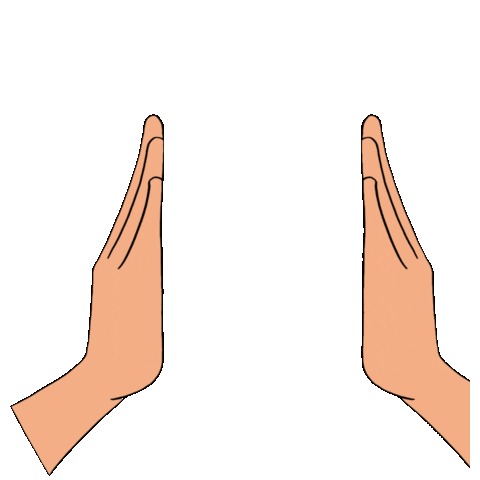

**->MODERATE DEPRESSION**

**ANJALI MUDRA INSTRUCTIONS**

• Step 1: Sit comfortably with your back straight.

• Step 2: Bring your palms together in front of your chest, fingers pointing upward.

• Step 3: Close your eyes and inhale and exhale slowly while holding this mudra.

• Practice this mudra for a minimum of 20 minutes.

 
     *Fact: Anjali Mudra represents gratitude and balance.*
 

No emergency at the moment.


In [ ]:
import requests
from IPython.display import Image, display, Markdown

# Load the sadness level from your model
sadness_level = normalized_sad

# Define paths to GIFs and instructions for mudras
mudra_paths = {
    "chin_mudra": "/content/drive/MyDrive/Datasets/Solutions/Chin-mudra.gif",
    "anjali_mudra": "/content/drive/MyDrive/Datasets/Solutions/Anjali-mudra.gif",
    "prana_mudra": "/content/drive/MyDrive/Datasets/Solutions/Prana-mudra.gif",
}

mudra_instructions = {
    "chin_mudra": [
        "**->MILD DEPRESSION**\n",
        "**CHIN  MUDRA INSTRUCTIONS**\n",
        "• Step 1: Sit comfortably with your back straight and your hands resting on your knees.\n",
        "• Step 2: Join the tip of your thumb with the tip of your index finger, forming a circle.\n",
        "• Step 3: Close your eyes and inhale and exhale slowly while holding this mudra.\n",
        "• Practice this mudra for a minimum of 20 minutes.\n",
        " ",
        "    *Fact: Chin Mudra can help calm the mind and improve concentration.*",
        " "
    ],
    "anjali_mudra": [
        "**->MODERATE DEPRESSION**\n",
        "**ANJALI MUDRA INSTRUCTIONS**\n",
        "• Step 1: Sit comfortably with your back straight.\n",
        "• Step 2: Bring your palms together in front of your chest, fingers pointing upward.\n",
        "• Step 3: Close your eyes and inhale and exhale slowly while holding this mudra.\n",
        "• Practice this mudra for a minimum of 20 minutes.\n",
        " ",
        "     *Fact: Anjali Mudra represents gratitude and balance.*",
        " "
    ],
    "prana_mudra": [
        "**->SEVERE DEPRESSION**\n",
        "**PRANA MUDRA INSTRUCTIONS**\n",
        "• Step 1: Sit comfortably with your back straight.\n",
        "• Step 2: Touch the tips of your ring finger and little finger to the tip of your thumb, while keeping the other two fingers extended.\n",
        "• Step 3: Close your eyes and inhale and exhale slowly while holding this mudra.\n",
        "• Practice this mudra for a minimum of 20 minutes.\n",
        " ",
        "    *Fact: Prana Mudra is associated with vital life force energy.*",
        " "

    ],
}

# Determine which mudra to show based on sadness level
if sadness_level <= 0.4:
    mudra = "chin_mudra"
elif 0.4 < sadness_level <= 0.6:
    mudra = "anjali_mudra"
elif 0.6 < sadness_level < 0.9:
    mudra = "prana_mudra"
else:
    mudra = None

# Display the mudra GIF and instructions with Markdown formatting
if mudra:
    display(Image(filename=mudra_paths[mudra]))
    formatted_instructions = mudra_instructions[mudra]
    display(Markdown('\n'.join(formatted_instructions)))

# Check if sadness level is above 0.9
if sadness_level > 0.9:
    print("\n**->EXTREME DEPRESSION**")
    print("\n\033[91mEMERGENCY HELPLINE-- Toll-Free Mental Health Rehabilitation Helpline Kiran: 1800-599-0019\n")
    print("\033[0mFinding nearby mental healthcare centers and clinics...\n")

    # Function to fetch user's location using GPS coordinates
    def get_user_location():
        try:
            response = requests.get("https://ipinfo.io")
            data = response.json()
            if "loc" in data:
                loc = data["loc"].split(",")
                user_latitude, user_longitude = loc
                print("Location Data:", data)  # Print location data here
                return user_latitude, user_longitude
            else:
                return None
        except Exception as e:
            print(f"Error fetching user location: {str(e)}")
            return None

    # Get the user's location
    user_location = get_user_location()

    if user_location:
        user_latitude, user_longitude = user_location
        print(f"User's Location - Latitude: {user_latitude}, Longitude: {user_longitude}\n")
    else:
        print("Unable to fetch user's location.\n")

    # Function to find nearby mental healthcare centers and clinics using HERE Geocoding and Search API
    def find_nearby_mental_health_centers(latitude, longitude):
        try:
            here_api_key = "rgnKMs99zei9oKTYtYo0KSiEsomx2TUF88XMO12VP0c"
            here_api_url = f"https://discover.search.hereapi.com/v1/discover"
            params = {
                "at": f"{latitude},{longitude}",
                "q": "mental healthcare",
                "apiKey": here_api_key,
            }
            response = requests.get(here_api_url, params=params)
            data = response.json()

            if "items" in data:
                healthcare_centers = data["items"]
                return healthcare_centers
            else:
                return []

        except Exception as e:
            print(f"Error finding nearby healthcare centers: {str(e)}")
            return []

    # Find nearby mental healthcare centers and clinics
    if user_location:
        nearby_healthcare_centers = find_nearby_mental_health_centers(user_latitude, user_longitude)

        if nearby_healthcare_centers:
            print("**Nearby Mental Healthcare Centres and Clinics:**\n")
            for idx, center in enumerate(nearby_healthcare_centers, 1):
                name = center.get("title", "N/A")
                contacts = center.get("contacts", [{}])[0]  # Get the first contact (if available)
                phone_numbers = contacts.get("phone", [{"value": "N/A"}])

                # Extract and join phone numbers
                phone_numbers_list = ', '.join([phone.get("value", "N/A") for phone in phone_numbers])

                print(f"{idx}) {name}")
                print(f"   Contact Numbers: {phone_numbers_list}\n")
        else:
            print("No nearby mental healthcare centers and clinics found.\n")
    else:
        print("No user location available.\n")

else:
    print("No emergency at the moment.")
